In [185]:
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from dateutil.rrule import rrule, DAILY
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### roll_data

In [186]:
roll_data = pd.read_csv('期貨行情/roll_data2023 (6).csv', encoding='Big5', index_col=False)
roll_data = roll_data[roll_data['交易時段'] == '一般']

In [187]:
def choose(row):
    return row['到期月份(週別)'][:13]
roll_data['到期月份(週別)'] = roll_data.apply(choose, axis = 1)

In [188]:
def length(row):
    return len(row['到期月份(週別)'])
roll_data['length'] = roll_data.apply(length, axis =1)

In [189]:
def change_to_datetime(row):
    return datetime.strptime(row['交易日期'], '%Y/%m/%d')
roll_data['交易日期'] = roll_data.apply(change_to_datetime, axis = 1)

In [190]:
def find_wed(start):
    first_day = start.replace(day=1)
    for i in range(7):
        if (first_day + timedelta(days=i)).isoweekday() == 3:
            x = first_day + timedelta(days=i)
        else:
            continue
    for i in range(6):
        if start <= x + timedelta(days=7)*i:
            return i+1
        else:
            continue
def third_wed(month:str):
    for i in range(7,25):
        date = month
        date = date + str(i)
        date2 = datetime.strptime(date, '%Y%m%d')
        if find_wed(date2) == 3:
            return date2
def find_lastweek(month:str):
    day1 = datetime.strptime(month, '%Y%m')
    begin = third_wed(month)-timedelta(days=1)
    end = third_wed(month)+timedelta(days=6)
    return begin, end

In [191]:
month = roll_data['交易日期'].iloc[0].strftime('%Y%m')
begin, end = find_lastweek(month)
date_range = pd.date_range(start = begin, end = end)
roll_data = roll_data.loc[roll_data['交易日期'].isin(date_range)]

In [192]:
tick_data = roll_data[roll_data['length']==8]
roll_data = roll_data[roll_data['length']==13]

#### roll data

In [193]:
def pidtransformer(row):
    date = row['交易日期']
    if find_wed(date) <= 3:
        a = str(date)[:7].replace('-', '')
        date_after_month = date + relativedelta(months=1)
        b = str(date_after_month)[:7].replace('-', '')
        c = a + '/' + b
        if c == row['到期月份(週別)']:
            return 1
        else:
            return 0
    else:
        datadd1m = date + relativedelta(months=1)
        a = str(datadd1m)[:7].replace('-', '')
        datadd2m = datadd1m + relativedelta(months=1)
        b = str(datadd2m)[:7].replace('-', '')
        c = a + '/' + b
        if c == row['到期月份(週別)']:
            return 1
        else:
            return 0

roll_data['pid_tran'] = roll_data.apply(pidtransformer, axis = 1)
roll_data = roll_data[roll_data['pid_tran']==1]

In [194]:
roll_data = roll_data.iloc[:, [0, 2, 4, 5, 6]].set_index('交易日期', drop = True)
roll_data['最高價'] = roll_data['最高價'].astype(int)
roll_data['最低價'] = roll_data['最低價'].astype(int)
roll_data['收盤價'] = roll_data['收盤價'].astype(int)

#### tick data

In [195]:
def choose(row):
    return row['到期月份(週別)'][:6]
tick_data['到期月份(週別)'] = tick_data.apply(choose, axis = 1)

In [196]:
def pidtransformer2(row):
    date = row['交易日期']
    if find_wed(date) <= 3:
        a = date.strftime('%Y%m')
        if a == row['到期月份(週別)']:
            return 1
        else:
            return 0
    else:
        datadd1m = date + relativedelta(months=1)
        a = date.strftime('%Y%m')
        if a == row['到期月份(週別)']:
            return 1
        else:
            return 0
tick_data['pid_tran'] = tick_data.apply(pidtransformer2, axis = 1)
tick_data = tick_data[tick_data['pid_tran']==1]
tick_data = tick_data.set_index('交易日期')
tick_data['收盤價'] = tick_data['收盤價'].astype(int)

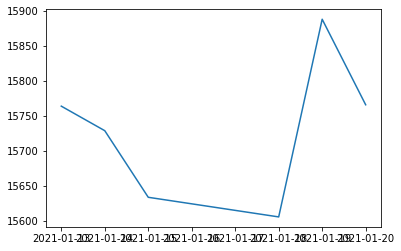

In [197]:
plt.plot(tick_data['收盤價'])

### Tx data

In [198]:
tx_data = pd.read_csv('TX_data.csv', encoding='Big5')

In [199]:
def change_to_datetime(row):
    return datetime.strptime(row['日期'], '%Y/%m/%d')
tx_data['日期'] = tx_data.apply(change_to_datetime, axis = 1)

In [200]:
tx_data = tx_data.loc[tx_data['身份別'] != '自營商']
tx_data = tx_data.loc[tx_data['日期'].isin(date_range)]
tx_data = tx_data.set_index('日期', drop=True)
tx_data_trust = tx_data.loc[tx_data['身份別'] == '投信']
tx_data_other = tx_data.loc[tx_data['身份別'] == '外資及陸資']

## 畫圖!!

In [201]:
roll_data.index = roll_data.index.strftime('%Y%m%d')

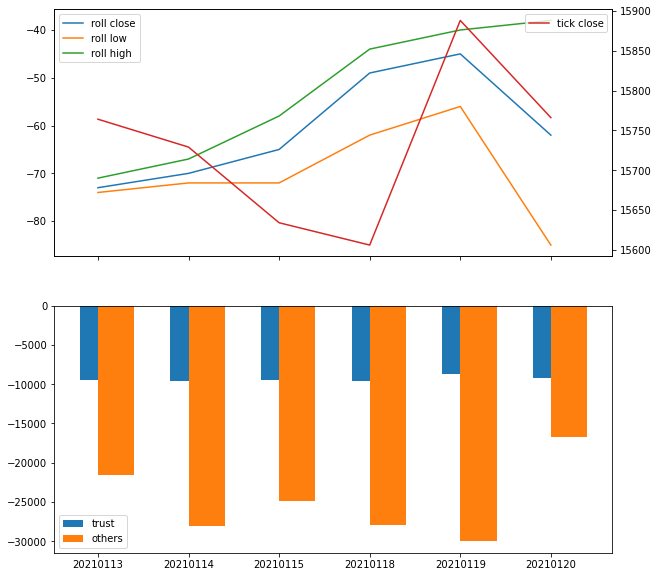

In [202]:
y1 = roll_data['收盤價']
y2 = roll_data['最低價']
y3 = roll_data['最高價']
y4 = tx_data_trust['多空未平倉口數淨額']
y5 = tx_data_other['多空未平倉口數淨額']
y6 = tick_data['收盤價']

fig, ax = plt.subplots(2,1,figsize=(10,10), sharex=True)
x = roll_data.index
ax[0].plot(x, y1, label = 'roll close')
ax[0].plot(x, y2, label = 'roll low')
ax[0].plot(x, y3, label = 'roll high')
ax[0].legend()
color = 'tab:red'
ax2 = ax[0].twinx()
ax2.plot(x, y6, label = 'tick close', color=color)
ax2.legend(loc='upper right')
# ax[0].set_ylim([-100, 0])

ax[1].bar(x, y4, width=0.4, label = 'trust')#, align='edge')
ax[1].bar(x, y5, width=0.4, label = 'others', align='edge')
ax[1].legend()
plt.show()
#plt.savefig(f"./圖片/{x[0]} 多空未平倉口數淨額.jpg")
#plt.close()

#### 爬蟲

In [203]:
from selenium import webdriver
from selenium.webdriver.support.ui import Select

In [204]:
driver = webdriver.Chrome()

In [205]:
driver.get('https://www.taifex.com.tw/cht/3/dlFutDailyMarketView')

In [206]:
day1 = datetime.strptime('202308', '%Y%m')
day28 = day1 + timedelta(days=30)
day_1 = []
day_28 = []
for i in range(36):
    day1 = day1 - relativedelta(months=1)
    day_str1 = day1.strftime('%Y/%m/%d')
    day_1.append(day_str1)
    day28 = day28 - relativedelta(months=1)
    day_str2 = day28.strftime('%Y/%m/%d')
    day_28.append(day_str2)

In [207]:
import time

In [ ]:
for start_date, end_date in zip(day_1, day_28):
    start = driver.find_element('id', 'queryStartDate')
    start.clear()
    start.send_keys(f'{start_date}')
    time.sleep(1)
    end = driver.find_element('id', 'queryEndDate')
    end.clear()
    end.send_keys(f'{end_date}')
    time.sleep(1)
    table = driver.find_element('id', 'commodity_idt')
    table.click()
    time.sleep(5)
    select = Select(driver.find_element('name', 'commodity_idt'))
    select.select_by_value('TX')
    download = driver.find_element('id', 'button4')
    download.click()

In [ ]:
from selenium import webdriver
from selenium.webdriver.support.ui import Select
import time

driver = webdriver.Chrome()

driver.get('https://www.taifex.com.tw/cht/3/dlFutDailyMarketView')

day1 = datetime.strptime('202308', '%Y%m')
day28 = day1 + timedelta(days=30)
day_1 = []
day_28 = []
for i in range(36):
    day1 = day1 - relativedelta(months=1)
    day_str1 = day1.strftime('%Y/%m/%d')
    day_1.append(day_str1)
    day28 = day28 - relativedelta(months=1)
    day_str2 = day28.strftime('%Y/%m/%d')
    day_28.append(day_str2)

for start_date, end_date in zip(day_1, day_28):
    start = driver.find_element('id', 'queryStartDate')
    start.clear()
    start.send_keys(f'{start_date}')
    time.sleep(1)
    end = driver.find_element('id', 'queryEndDate')
    end.clear()
    end.send_keys(f'{end_date}')
    time.sleep(1)
    table = driver.find_element('id', 'commodity_idt')
    table.click()
    time.sleep(5)
    select = Select(driver.find_element('name', 'commodity_idt'))
    select.select_by_value('TX')
    download = driver.find_element('id', 'button4')
    download.click()